In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from itertools import combinations
import csv
from scipy.signal import resample_poly
import umap
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from pathlib import Path
import glob
import shutil
import os
import pickle


import sys
sys.path.append('/storage3/eva/code/remapping/src')
import path_formatting as pf
import motive
import oe

/storage3/eva/apps/anaconda3/envs/nma/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fs_pos = 120

date = "20250909"
animal = "eb03"

ks_path = rf'X:\eva\data\processed\{animal}\{animal}_{date}\kilosort'
ks_path = pf.w2l(ks_path)

csv_path = rf'X:\eva\data\processed\{animal}\{animal}_{date}\motive\out_csv'
csv_path = pf.w2l(csv_path)

res_path = rf'X:\eva\code\neuropixels\results\{animal}\{animal}_{date}'
res_path = pf.w2l(res_path)
# Create the folder if it doesn't exist
os.makedirs(res_path, exist_ok=True)

pa_path = Path(res_path) / "pa" #pa - populational analysis
pa_path.mkdir(parents=True, exist_ok=True) # Create the folder if it doesn't exist

ks_path, res_path, pa_path,csv_path

('/storage3/eva/data/processed/eb03/eb03_20250909/kilosort',
 '/storage3/eva/code/neuropixels/results/eb03/eb03_20250909',
 PosixPath('/storage3/eva/code/neuropixels/results/eb03/eb03_20250909/pa'),
 '/storage3/eva/data/processed/eb03/eb03_20250909/motive/out_csv')

In [3]:
goodspiketimes = oe.ks_load(ks_path)
res_path_path = Path(res_path)
with open(Path(res_path) / f"preprocessing/behav_periods_{animal}_{date}.pkl", "rb") as f:
    periods = pickle.load(f)

Sup! U have...
67 phy-good clusters


In [4]:
csv_dict = motive.get_csv_dict(csv_path)
with open(Path(f'{res_path}/preprocessing') / f"meta_{date}.pkl", "rb") as f:
    meta = pickle.load(f)
meta

{'of1': '20250909_1', 'of2': '20250909_2', 'of3': '20250909_3'}

In [5]:
periods

{'sl1': [np.int64(1), np.int64(55636839)],
 'of1': [np.int64(55637339), np.int64(109752468)],
 'sl2': [np.int64(110203161), np.int64(164604073)],
 'of2': [np.int64(164993301), np.int64(219019456)],
 'sl3': [np.int64(219329946), np.int64(273560106)],
 'of3': [np.int64(274088922), np.int64(323868824)],
 'sl4': [np.int64(324132004), np.int64(385931983)]}

In [6]:
spikes_by_periods = {}

for of in periods.keys():
    start, end = periods[of]

    spikes_by_periods[of] = {}
    for unit in goodspiketimes.keys():
        spikes = goodspiketimes[unit]
        spikes_in_trial = spikes[(spikes >= start) & (spikes <= end)] - start
        spikes_by_periods[of][unit] = spikes_in_trial

In [7]:
with open(Path(res_path) / f"unit_classes_{date}.pkl", "rb") as f:
    unit_class_dict = pickle.load(f)

In [ ]:
rm_dict = {} # of, unit
xy_bins = {} # of, x_edges/z_edges

for of in meta.keys():

    with open(Path(res_path) / f"pf/pf_data_dict_{of}_{date}.pkl", "rb") as f:
        pf_data_dict = pickle.load(f)

    rm_dict[of] = pf_data_dict['rm']

    xy_bins[of] = {}
    xy_bins[of]['x_edges'] = pf_data_dict['x_edges']
    xy_bins[of]['z_edges'] = pf_data_dict['z_edges']

In [13]:
def build_population_matrix(fr_dict, units, of_key):
    mats = [fr_dict[of_key][u].flatten() for u in units]
    mat = np.vstack(mats)  # (n_units, n_bins)
    valid_mask = ~np.all(np.isnan(mat), axis=0)
    return mat[:, valid_mask], valid_mask

def build_across_ofs(fr_dict, units, ofs=('of1','of2','of3')):
    mats, masks, lengths = [], [], []
    for of in ofs:
        mat, mask = build_population_matrix(fr_dict, units, of)
        mats.append(mat)
        masks.append(mask)
        lengths.append(mat.shape[1])  # how many valid bins in this OF
    full_mat = np.hstack(mats)  # concat bins across OFs
    return full_mat, masks, lengths

umap_kwargs = dict(n_neighbors=20, min_dist=0.5, metric='euclidean', random_state=42)
def run_umap(full_mat, umap_kwargs):
    X = full_mat.T  # (n_bins_total, n_units)
    reducer = umap.UMAP(**umap_kwargs)
    return reducer.fit_transform(X)  # (n_bins_total, 2)

def split_embedding(emb, lengths, ofs=('of1','of2','of3')):
    emb_split, start = {}, 0
    for of, L in zip(ofs, lengths):
        emb_split[of] = emb[start:start+L]
        start += L
    return emb_split

def plot_umap(emb, color, title=""):
    plt.figure(figsize=(4,3))
    plt.scatter(emb[:,0], emb[:,1], c=color, cmap="viridis", s=20)
    plt.colorbar(label=title)
    plt.title(title)
    plt.show()

In [10]:
uoi = list(goodspiketimes.keys())

In [34]:
# Split by cell type
pyr_units = [u for u in uoi if unit_class_dict[u] == "pyr"]
int_units = [u for u in uoi if unit_class_dict[u] == "int"]

# Run UMAP for pyramidal cells
pyr_mat, pyr_masks, pyr_lengths = build_across_ofs(rm_dict, pyr_units)
emb_pyr = run_umap(pyr_mat,umap_kwargs)
emb_pyr_split = split_embedding(emb_pyr, pyr_lengths)

# Same for interneurons
int_mat, int_masks, int_lengths = build_across_ofs(rm_dict, int_units)
emb_int = run_umap(int_mat,umap_kwargs)
emb_int_split = split_embedding(emb_int, int_lengths)

/storage3/eva/apps/anaconda3/envs/nma/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/storage3/eva/apps/anaconda3/envs/nma/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [33]:
def get_flat_bin_coords(xy_bins, of_key):
    x_edges = xy_bins[of_key]['x_edges']
    z_edges = xy_bins[of_key]['z_edges']
    
    # bin centers
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    z_centers = 0.5 * (z_edges[:-1] + z_edges[1:])
    
    # 2D grid -> flatten
    xx, zz = np.meshgrid(x_centers, z_centers, indexing="xy")
    return xx.flatten(), zz.flatten()

In [34]:
x_colors, z_colors = {}, {}
for of, mask in zip(('of1','of2','of3'), pyr_masks):
    x_flat, z_flat = get_flat_bin_coords(xy_bins, of)
    x_colors[of] = x_flat[mask]
    z_colors[of] = z_flat[mask]

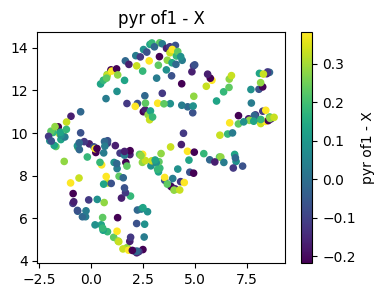

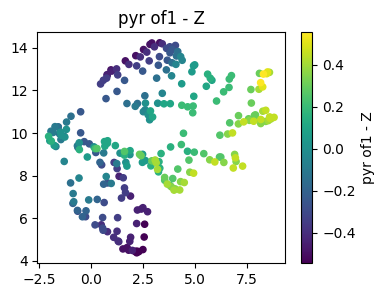

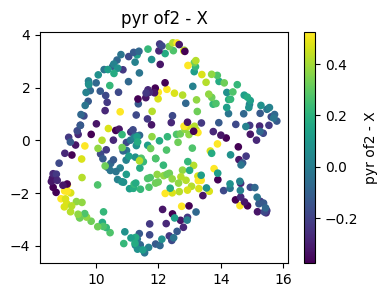

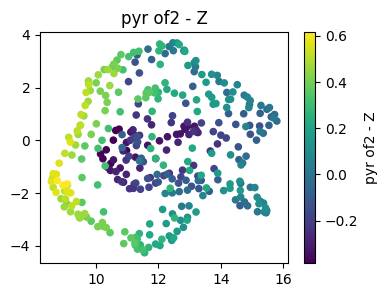

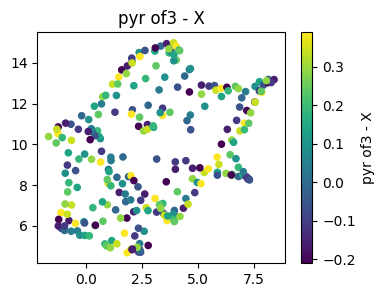

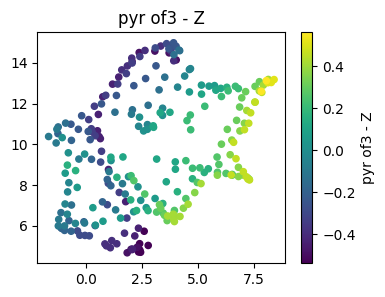

In [ ]:
for of in ('of1','of2','of3'):
    plot_umap(emb_pyr_split[of], x_colors[of], title=f"pyr {of} - X")
    plot_umap(emb_pyr_split[of], z_colors[of], title=f"pyr {of} - Z")
    

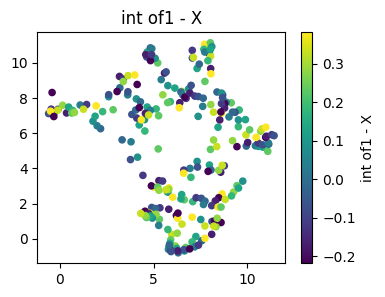

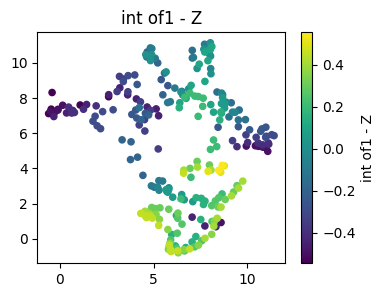

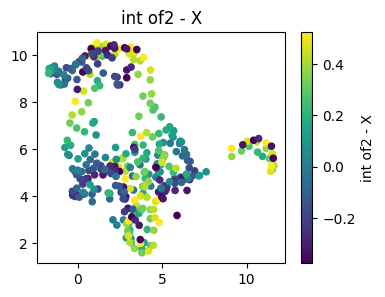

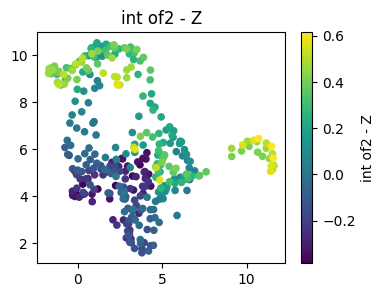

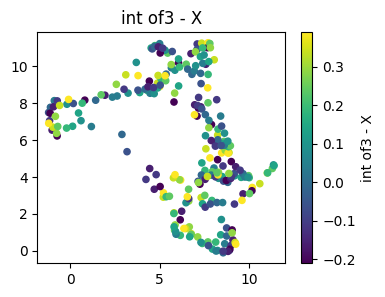

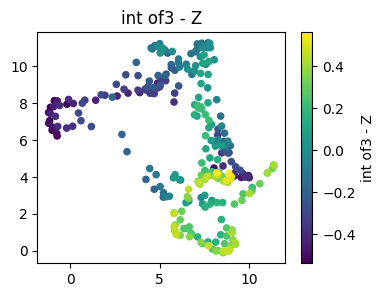

In [43]:
for of in ('of1','of2','of3'):
    plot_umap(emb_int_split[of], x_colors[of], title=f"int {of} - X")
    plot_umap(emb_int_split[of], z_colors[of], title=f"int {of} - Z")
    

## Pitch umap

In [41]:
pitches = {}

for of in rm_dict.keys():

    pitches[of] = {}

    with open(Path(res_path) / f"pitch/pf_data_dict1d_{of}_{date}.pkl", "rb") as f:
        pitch_dict = pickle.load(f)

    pitches[of]['pitch_centers'] = pitch_dict['pitch_centers']
    pitches[of]["rm"] = pitch_dict['rm']

pitches

{'of1': {'pitch_centers': array([-87.5, -82.5, -77.5, -72.5, -67.5, -62.5, -57.5, -52.5, -47.5,
         -42.5, -37.5, -32.5, -27.5, -22.5, -17.5, -12.5,  -7.5,  -2.5,
           2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,
          47.5,  52.5,  57.5,  62.5,  67.5,  72.5]),
  'rm': {23: array([3.42862447, 2.86146587, 3.03483137, 4.09076812, 5.71817865,
          6.76427877, 6.90951177, 6.55263341, 5.96303521, 5.3615253 ,
          5.31573478, 5.43998572, 5.61287968, 5.76188486, 5.61377327,
          5.40133852, 5.39402668, 5.15554193, 4.05568376, 2.7979388 ,
          1.92119467, 1.29404205, 0.77694749, 0.43863004, 0.28108466,
          0.21373433, 0.24190879, 0.19679075, 0.        , 0.        ,
          0.        ,        nan,        nan]),
   126: array([0.        , 0.19509995, 0.30348314, 0.28902166, 0.20422067,
          0.08665209, 0.03020185, 0.01329809, 0.01077332, 0.02311002,
          0.02068379, 0.        , 0.        , 0.        , 0.        ,
          0.  

In [42]:
# --- Build population matrix ---
def build_population_matrix_pitch(pitches, units, of_key):
    """Rows = units, Cols = pitch bins (valid only)."""
    mats = [pitches[of_key]['rm'][u].flatten() for u in units]
    mat = np.vstack(mats)  # (n_units, n_pitch_bins)
    
    valid_mask = ~np.all(np.isnan(mat), axis=0)
    return mat[:, valid_mask], valid_mask

def build_across_ofs_pitch(pitches, units, ofs=('of1','of2','of3')):
    """Concatenate bins across OFs."""
    mats, masks, lengths = [], [], []
    for of in ofs:
        mat, mask = build_population_matrix_pitch(pitches, units, of)
        mats.append(mat)
        masks.append(mask)
        lengths.append(mat.shape[1])
    full_mat = np.hstack(mats)
    return full_mat, masks, lengths

# --- UMAP ---
def run_umap(full_mat, umap_kwargs):
    X = full_mat.T  # (n_bins_total, n_units)
    reducer = umap.UMAP(**umap_kwargs)
    return reducer.fit_transform(X)

def split_embedding(emb, lengths, ofs=('of1','of2','of3')):
    emb_split, start = {}, 0
    for of, L in zip(ofs, lengths):
        emb_split[of] = emb[start:start+L]
        start += L
    return emb_split

# --- Plot ---
def plot_umap(emb, color, title=""):
    plt.figure(figsize=(4,3))
    sc = plt.scatter(emb[:,0], emb[:,1], c=color, cmap="viridis", s=20)
    plt.colorbar(sc, label=title)
    plt.title(title)
    plt.show()

/storage3/eva/apps/anaconda3/envs/nma/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


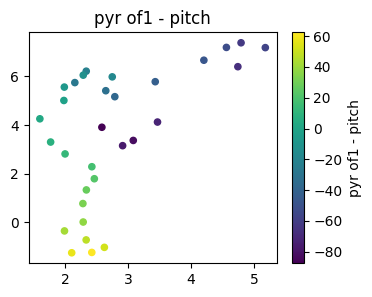

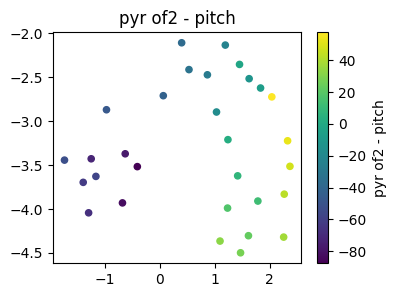

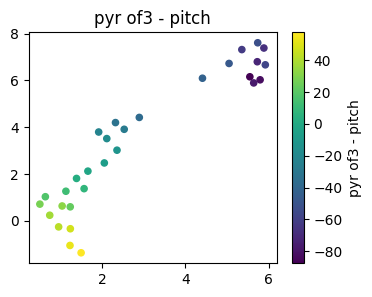

In [47]:
umap_kwargs = dict(n_neighbors=20, min_dist=0.5, metric='euclidean', random_state=42)

# Select units by class
pyr_units = [u for u in uoi if unit_class_dict[u] == "pyr"]
int_units = [u for u in uoi if unit_class_dict[u] == "int"]

# Run for pyramidal cells
pyr_mat, pyr_masks, pyr_lengths = build_across_ofs_pitch(pitches, pyr_units)
emb_pyr = run_umap(pyr_mat, umap_kwargs)
emb_pyr_split = split_embedding(emb_pyr, pyr_lengths)

# Pitch colors
pyr_pitch_colors = {
    of: pitches[of]['pitch_centers'][mask]
    for of, mask in zip(('of1','of2','of3'), pyr_masks)
}

# Plot
for of in ('of1','of2','of3'):
    plot_umap(emb_pyr_split[of], pyr_pitch_colors[of], title=f"pyr {of} - pitch")
    

/storage3/eva/apps/anaconda3/envs/nma/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


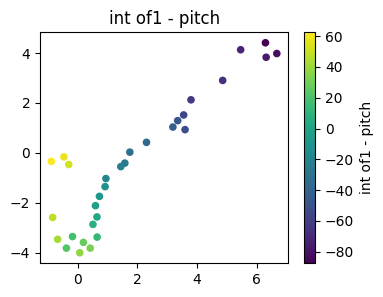

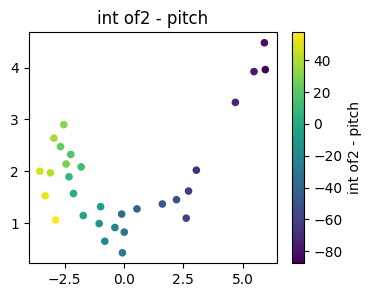

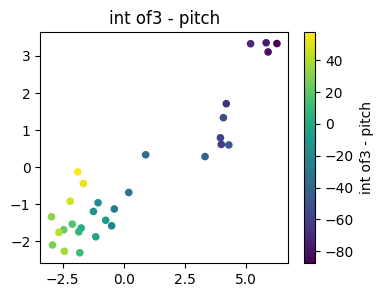

In [84]:
# Run for int cells
int_mat, int_masks, int_lengths = build_across_ofs_pitch(pitches, int_units)
emb_int= run_umap(int_mat, umap_kwargs)
emb_int_split = split_embedding(emb_int, int_lengths)

# Pitch colors
int_pitch_colors = {
    of: pitches[of]['pitch_centers'][mask]
    for of, mask in zip(('of1','of2','of3'), int_masks)
}

# Plot
for of in ('of1','of2','of3'):
    plot_umap(emb_int_split[of], int_pitch_colors[of], title=f"int {of} - pitch")
    

In [73]:
def plot_by_of(emb, lengths, ofs=('of1','of2','of3'), title="",figsize=(5,4)):
    """
    emb: (n_bins_total, 2)
    lengths: list of bin counts per OF
    ofs: names of open fields
    """
    start = 0
    colors = {'of1': 'tab:blue', 'of2': 'tab:orange', 'of3': 'tab:green'}
    
    plt.figure(figsize=figsize)
    for of, L in zip(ofs, lengths):
        plt.scatter(emb[start:start+L, 0], emb[start:start+L, 1],
                    c=colors[of], s=20, alpha=0.8, label=of)
        start += L
    plt.legend()
    plt.title(title)
    plt.show()

/storage3/eva/apps/anaconda3/envs/nma/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


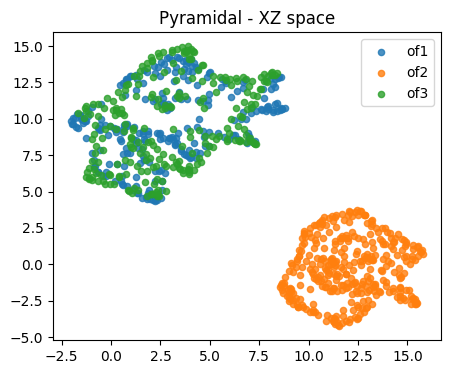

/storage3/eva/apps/anaconda3/envs/nma/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


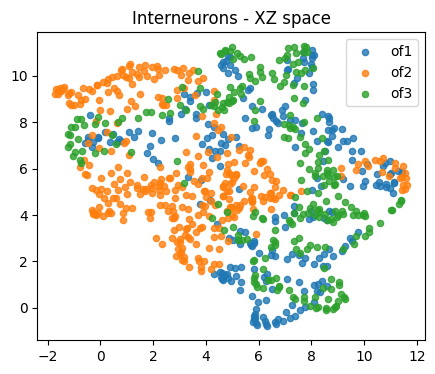

In [51]:
# Pyramidal cells
pyr_mat, pyr_masks, pyr_lengths = build_across_ofs(rm_dict, pyr_units)  # using spatial FR dict
emb_pyr_xz = run_umap(pyr_mat, umap_kwargs)
plot_by_of(emb_pyr_xz, pyr_lengths, title="Pyramidal - XZ space")

# Interneurons
int_mat, int_masks, int_lengths = build_across_ofs(rm_dict, int_units)
emb_int_xz = run_umap(int_mat, umap_kwargs)
plot_by_of(emb_int_xz, int_lengths, title="Interneurons - XZ space")

/storage3/eva/apps/anaconda3/envs/nma/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


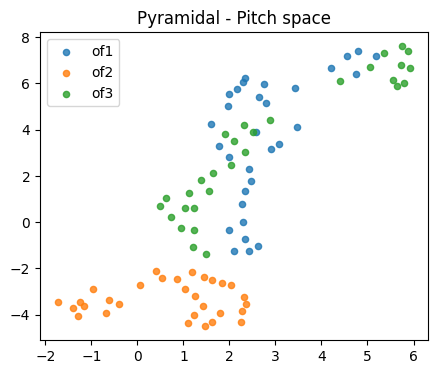

/storage3/eva/apps/anaconda3/envs/nma/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


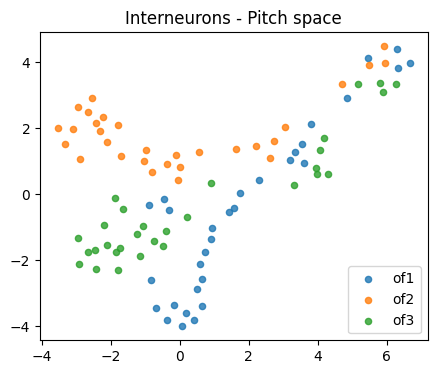

In [52]:
# Pyramidal cells
pyr_mat_pitch, pyr_masks_pitch, pyr_lengths_pitch = build_across_ofs_pitch(pitches, pyr_units)
emb_pyr_pitch = run_umap(pyr_mat_pitch, umap_kwargs)
plot_by_of(emb_pyr_pitch, pyr_lengths_pitch, title="Pyramidal - Pitch space")

# Interneurons
int_mat_pitch, int_masks_pitch, int_lengths_pitch = build_across_ofs_pitch(pitches, int_units)
emb_int_pitch = run_umap(int_mat_pitch, umap_kwargs)
plot_by_of(emb_int_pitch, int_lengths_pitch, title="Interneurons - Pitch space")

## PCA and eigen stuff

In [24]:
from sklearn.decomposition import PCA

def run_pca(full_mat, n_components=None):
    X = full_mat.T  # (n_bins_total, n_units)
    pca = PCA(n_components=n_components) 
    return pca.fit_transform(X), pca.components_, pca.explained_variance_ratio_  # (n_bins_total, 2)

In [25]:
# Split by cell type
pyr_units = [u for u in uoi if unit_class_dict[u] == "pyr"]
int_units = [u for u in uoi if unit_class_dict[u] == "int"]

# PCA for PYR
pyr_mat, pyr_masks, pyr_lengths = build_across_ofs(rm_dict, pyr_units)
pc_pyr, pc_pyr_loadings, pc_pyr_expl_var = run_pca(pyr_mat)
pc_pyr_split = split_embedding(pc_pyr, pyr_lengths)

# PCA for INTER
int_mat, int_masks, int_lengths = build_across_ofs(rm_dict, int_units)
pc_int, pc_int_loadings, pc_int_expl_var = run_pca(int_mat)
pc_int_split = split_embedding(pc_int, int_lengths)

In [28]:
def plot_pc_loadings(loadings):

    plt.figure(figsize=(6, 4))
    plt.imshow(loadings, cmap='bwr', aspect='auto')
    plt.colorbar(label='Loading weight')
    plt.xlabel('Feature')
    plt.ylabel('PC')
    plt.title('PCA Loadings')
    plt.tight_layout()
    plt.show()

def plot_explained_var(explained_var):
    plt.figure(figsize=(6, 4))
    plt.bar(np.arange(1, len(explained_var) + 1),
            explained_var,
            alpha=0.7, label='Individual')
    plt.plot(np.cumsum(explained_var), marker='o', label='Cumulative')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Explained Variance')
    plt.legend()
    plt.tight_layout()
    plt.show()

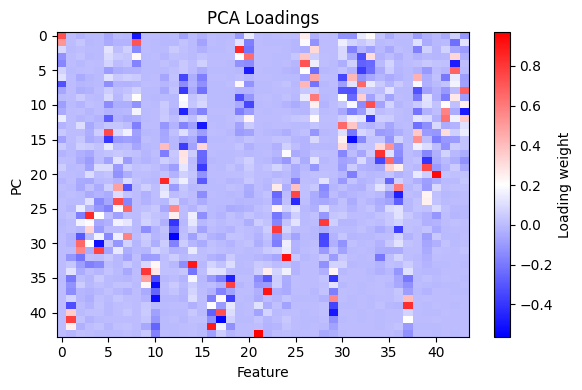

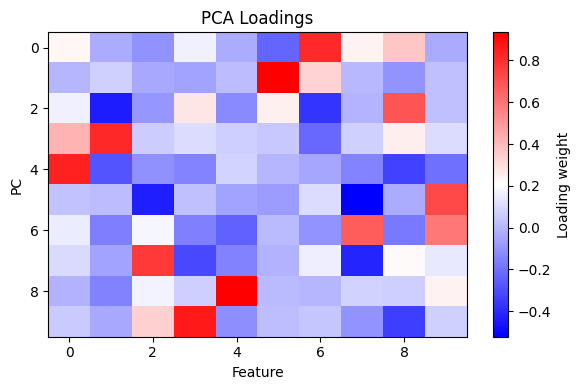

In [31]:
plot_pc_loadings(pc_pyr_loadings)
plot_pc_loadings(pc_int_loadings)

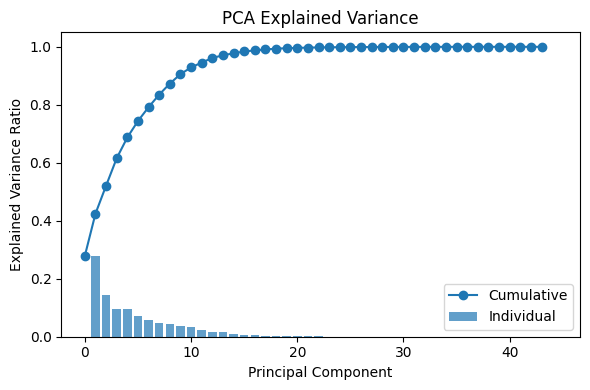

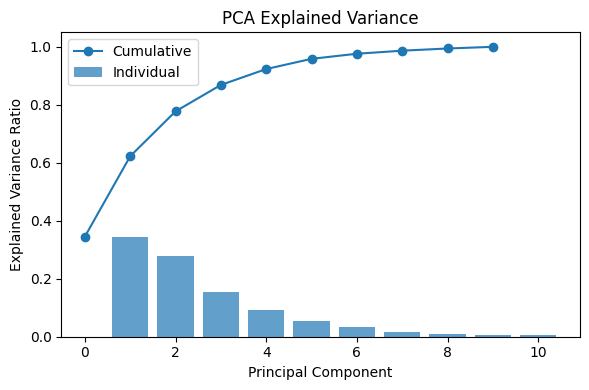

In [32]:
plot_explained_var(pc_pyr_expl_var)
plot_explained_var(pc_int_expl_var)

Principal axes (eigenvectors) = the directions of variance in your data

Explained variance (eigenvalues) = how much variance is along each direction

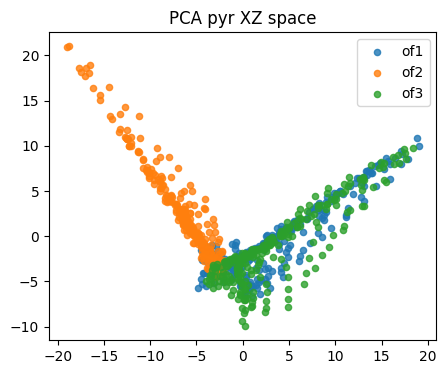

In [37]:
plot_by_of(pc_pyr, pyr_lengths, title="PCA pyr XZ space")

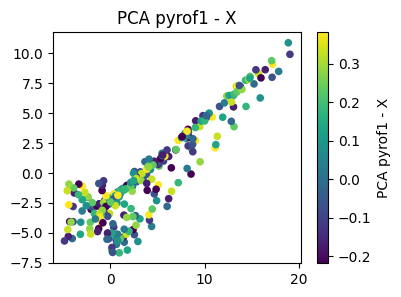

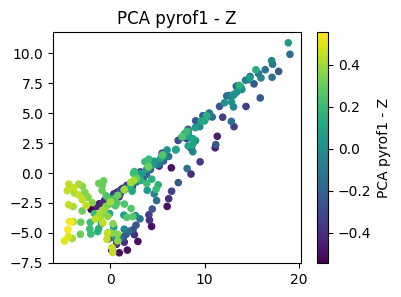

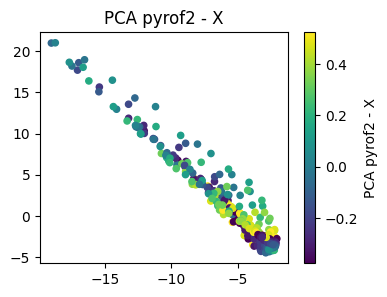

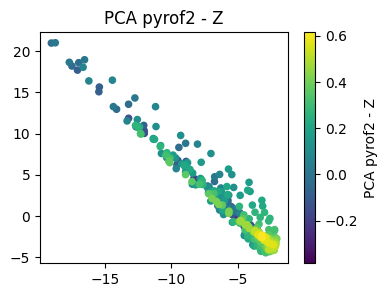

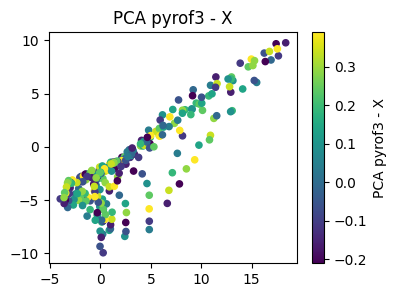

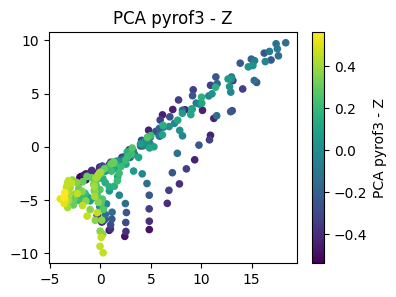

In [35]:
for of in ('of1','of2','of3'):
    plot_umap(pc_pyr_split[of], x_colors[of], title=f"PCA pyr{of} - X")
    plot_umap(pc_pyr_split[of], z_colors[of], title=f"PCA pyr{of} - Z")

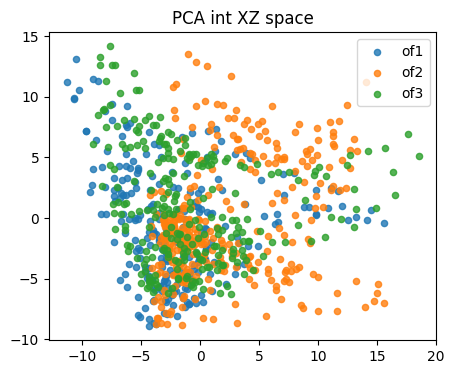

In [38]:
plot_by_of(pc_int, int_lengths, title="PCA int XZ space")

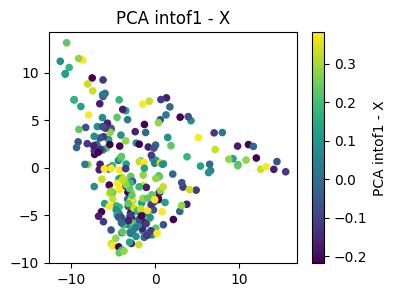

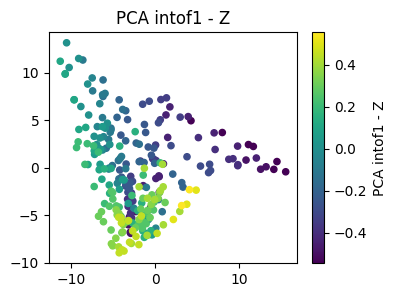

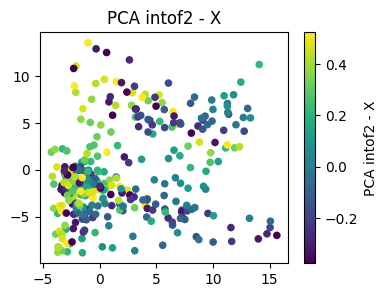

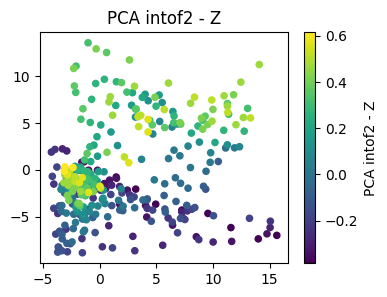

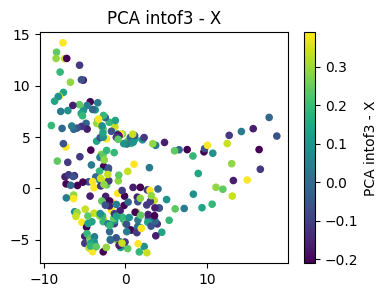

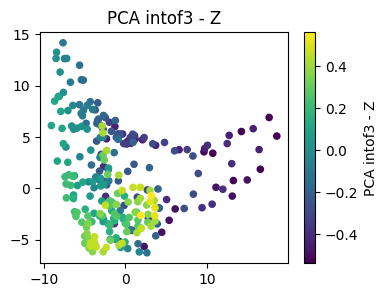

In [39]:
for of in ('of1','of2','of3'):
    plot_umap(pc_int_split[of], x_colors[of], title=f"PCA int{of} - X")
    plot_umap(pc_int_split[of], z_colors[of], title=f"PCA int{of} - Z")

In [ ]:
umap_kwargs = dict(n_neighbors=20, min_dist=0.5, metric='euclidean', random_state=42)

# Select units by class
pyr_units = [u for u in uoi if unit_class_dict[u] == "pyr"]
int_units = [u for u in uoi if unit_class_dict[u] == "int"]

# Run for pyramidal cells
pyr_mat, pyr_masks, pyr_lengths = build_across_ofs_pitch(pitches, pyr_units)
emb_pyr = run_umap(pyr_mat, umap_kwargs)
emb_pyr_split = split_embedding(emb_pyr, pyr_lengths)

# Pitch colors
pyr_pitch_colors = {
    of: pitches[of]['pitch_centers'][mask]
    for of, mask in zip(('of1','of2','of3'), pyr_masks)
}

# Plot
for of in ('of1','of2','of3'):
    plot_umap(emb_pyr_split[of], pyr_pitch_colors[of], title=f"pyr {of} - pitch")

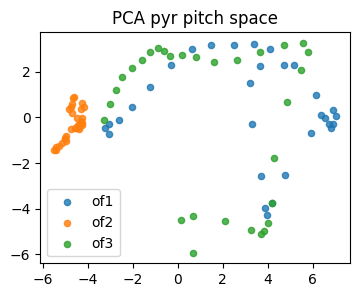

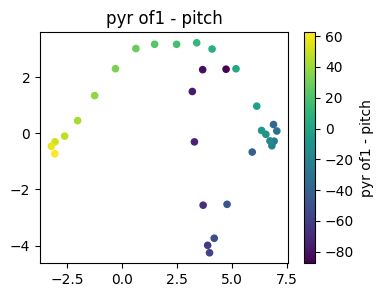

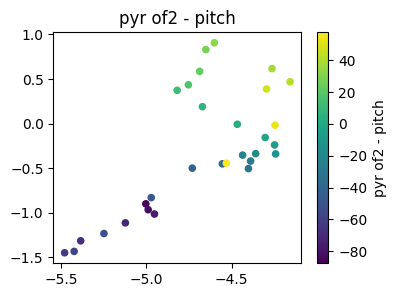

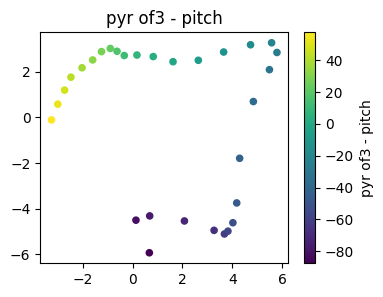

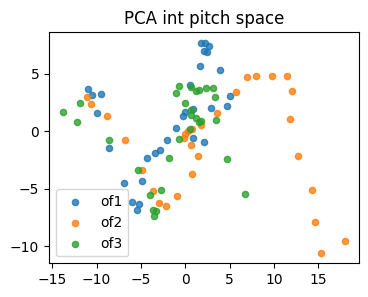

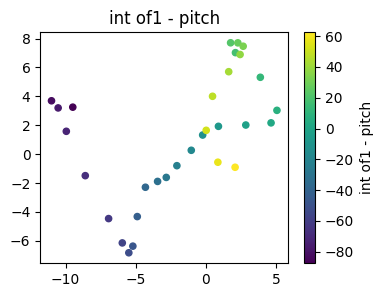

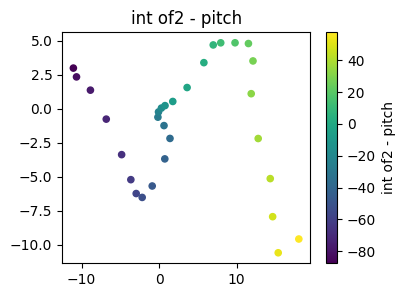

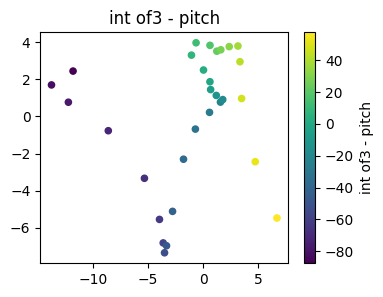

In [87]:
# Pyramidal cells
pyr_mat_pitch, pyr_masks_pitch, pyr_lengths_pitch = build_across_ofs_pitch(pitches, pyr_units)
pc_pyr_pitch, pc_pyr_loadings_pitch, pc_pyr_expl_var_pitch = run_pca(pyr_mat_pitch)
plot_by_of(pc_pyr_pitch, pyr_lengths_pitch, title="PCA pyr pitch space", figsize=(4,3))

pc_pyr_pitch_split = split_embedding(pc_pyr_pitch, pyr_lengths_pitch)
pcpyr_pitch_colors = {
    of: pitches[of]['pitch_centers'][mask]
    for of, mask in zip(('of1','of2','of3'), pyr_masks_pitch)
}
for of in ('of1','of2','of3'):
    plot_umap(pc_pyr_pitch_split[of], pcpyr_pitch_colors[of], title=f"pyr {of} - pitch")

# Interneurons
int_mat_pitch, int_masks_pitch, int_lengths_pitch = build_across_ofs_pitch(pitches, int_units)
pc_int_pitch, pc_int_loadings_pitch, pc_int_expl_var_pitch = run_pca(int_mat_pitch)
plot_by_of(pc_int_pitch, int_lengths_pitch, title="PCA int pitch space", figsize=(4,3))

pc_int_pitch_split = split_embedding(pc_int_pitch, int_lengths_pitch)
pcint_pitch_colors = {
    of: pitches[of]['pitch_centers'][mask]
    for of, mask in zip(('of1','of2','of3'), int_masks_pitch)
}
for of in ('of1','of2','of3'):
    plot_umap(pc_int_pitch_split[of], pcint_pitch_colors[of], title=f"int {of} - pitch")

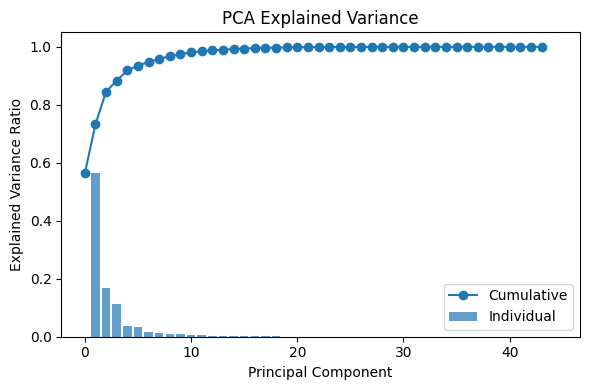

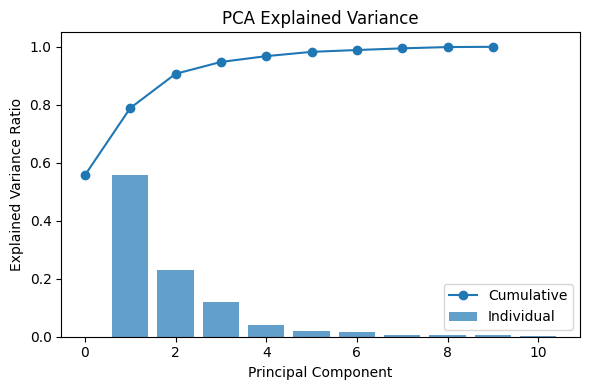

In [80]:
plot_explained_var(pc_pyr_expl_var_pitch)
plot_explained_var(pc_int_expl_var_pitch)

In [81]:
pc_pyr_split_p = split_embedding(pyr_mat_pitch, pyr_lengths_pitch)
pc_int_split_p = split_embedding(int_mat_pitch, int_lengths_pitch)

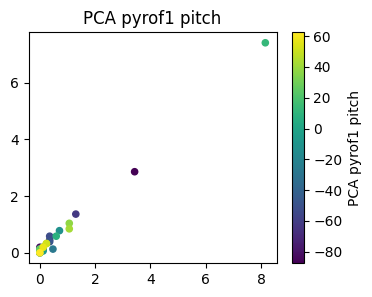

ValueError: 'c' argument has 31 elements, which is inconsistent with 'x' and 'y' with size 10.

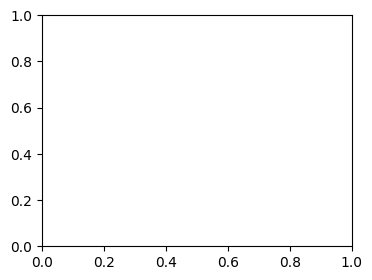

In [85]:
for of in ('of1','of2','of3'):
    plot_umap(pc_pyr_split_p[of], int_pitch_colors[of], title=f"PCA pyr{of} pitch")
    plot_umap(pc_int_split_p[of], int_pitch_colors[of], title=f"PCA int{of} pitch")